# Designing a U-Net

## Import Statements

In [1]:
import torch
import torch.nn as nn
import numpy as np

## U-Net Implementation

In [2]:
def get_padding(padding_type, kernel_size):
    assert padding_type in ['same', 'valid']
    if padding_type == 'same':
        return (kernel_size-1)//2
    return tuple(0 for _ in kernel_size)


def build_double_conv(inp_channels: int, output_channels: int, dropout_frac: float = 0.1):
    conv = nn.Sequential(
        nn.ZeroPad2d(get_padding('same', 3)),
        nn.Conv2d(inp_channels, output_channels, kernel_size=(3,3)),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout_frac, inplace=True),
        nn.ZeroPad2d(get_padding('same', 3)),
        nn.Conv2d(output_channels, output_channels, kernel_size=(3,3)),
        nn.ReLU(inplace=True),
    )
    return conv


def crop_tensor(orignal_tensor, target_tensor):
    orignal_size = orignal_tensor.size()[2]
    target_size = target_tensor.size()[2]
    delta = orignal_size - target_size
    delta = delta // 2
    return orignal_tensor[:, :, delta:orignal_size - delta, delta:orignal_size - delta]


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.MaxPool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = build_double_conv(2, 64)
        self.down_conv_2 = build_double_conv(64, 128)
        self.down_conv_3 = build_double_conv(128, 256)
        self.down_conv_4 = build_double_conv(256, 512)
        self.down_conv_5 = build_double_conv(512, 1024)

        ## Second Part of the architecture
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=(2,2),
            stride=2)
        self.up_conv_1 = build_double_conv(1024, 512)

        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=(2,2),
            stride=2)
        self.up_conv_2 = build_double_conv(512, 256)

        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=(2,2),
            stride=2)
        self.up_conv_3 = build_double_conv(256, 128)

        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=(2,2),
            stride=2)
        self.up_conv_4 = build_double_conv(128, 64)

        ## Output
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def forward(self, image):
        ## Encoder
        x1 = self.down_conv_1(image)  ## Skip connection
#         print(x1.shape)
        x2 = self.MaxPool_2x2(x1)
#         print(x2.shape)

        x3 = self.down_conv_2(x2)  ## Skip connection
#         print(x3.shape)
        x4 = self.MaxPool_2x2(x3)
#         print(x4.shape)

        x5 = self.down_conv_3(x4)  ## Skip connection
#         print(x5.shape)
        x6 = self.MaxPool_2x2(x5)
#         print(x6.shape)

        x7 = self.down_conv_4(x6)  ## Skip connection
#         print(x7.shape)
        x8 = self.MaxPool_2x2(x7)
#         print(x8.shape)

        x9 = self.down_conv_5(x8)
#         print(x9.shape)

        ## Decoder
        x = self.up_transpose_1(x9)
#         print(x.shape)
        y = crop_tensor(x7, x)
#         print(y.shape)
        x = self.up_conv_1(torch.cat([x, y], axis=1))
#         print(x.shape)

        x = self.up_transpose_2(x)
#         print(x.shape)
        y = crop_tensor(x5, x)
#         print(y.shape)
        x = self.up_conv_2(torch.cat([x, y], axis=1))
#         print(x.shape)

        x = self.up_transpose_3(x)
#         print(x.shape)
        y = crop_tensor(x3, x)
#         print(y.shape)
        x = self.up_conv_3(torch.cat([x, y], axis=1))
#         print(x.shape)

        x = self.up_transpose_4(x)
#         print(x.shape)
        y = crop_tensor(x1, x)
#         print(y.shape)
        x = self.up_conv_4(torch.cat([x, y], axis=1))
#         print(x.shape)

        ## Output
        x = self.output(x)
#         print(x.shape)
        return x

In [3]:
# image = torch.rand((1, 1, 572, 572))
# model = UNet()
# model(image)

## Dataset

In [4]:
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
from lib import loaders, modules

In [5]:
Radio_train = loaders.RadioUNet_c(phase="train")
Radio_val = loaders.RadioUNet_c(phase="val")
Radio_test = loaders.RadioUNet_c(phase="test")

image_datasets = {
    'train': Radio_train, 'val': Radio_val
}

batch_size = 1

dataloaders = {
    'train': DataLoader(Radio_train, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': DataLoader(Radio_val, batch_size=batch_size, shuffle=True, num_workers=1)
}

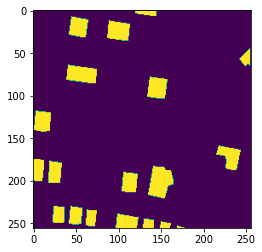

In [6]:
image, mask = Radio_train[0]
plt.imshow(image[0])
plt.show()

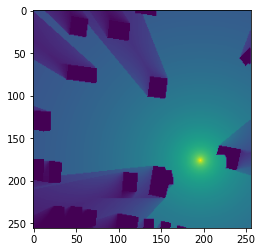

In [7]:
plt.imshow(mask[0])
plt.show()

## Image Dimensions

In [8]:
print(image.size())
print(mask.size())

torch.Size([2, 256, 256])
torch.Size([1, 256, 256])


The following are the dimensions of the image and will help in determining the shape of the UNet:
- The image or the input to the network has the following shape: 2 X 256 X 256. Thus it has 256 X 256 pixels with 2 channels.
- The mask or labels for the has one channel, and is of the same dimensions as the orignal image.

## Testing the model on a Random Tensor

In [9]:
random_image = torch.randn((1, 2, 256, 256))
model = UNet()
model.forward(random_image)

tensor([[[[ 0.0040, -0.0028, -0.0017,  ..., -0.0107, -0.0042,  0.0004],
          [ 0.0014, -0.0098,  0.0020,  ..., -0.0087, -0.0075, -0.0016],
          [-0.0092, -0.0111, -0.0022,  ..., -0.0113, -0.0126, -0.0096],
          ...,
          [-0.0082, -0.0129, -0.0135,  ..., -0.0091, -0.0093, -0.0104],
          [ 0.0029,  0.0033, -0.0293,  ..., -0.0123, -0.0009, -0.0125],
          [ 0.0039, -0.0079,  0.0046,  ..., -0.0022, -0.0026, -0.0035]]]],
       grad_fn=<ThnnConv2DBackward>)

## Model Summary

In [10]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(2,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 2, 258, 258]               0
            Conv2d-2         [-1, 64, 256, 256]           1,216
              ReLU-3         [-1, 64, 256, 256]               0
           Dropout-4         [-1, 64, 256, 256]               0
         ZeroPad2d-5         [-1, 64, 258, 258]               0
            Conv2d-6         [-1, 64, 256, 256]          36,928
              ReLU-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
         ZeroPad2d-9         [-1, 64, 130, 130]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
             ReLU-11        [-1, 128, 128, 128]               0
          Dropout-12        [-1, 128, 128, 128]               0
        ZeroPad2d-13        [-1, 128, 130, 130]               0
           Conv2d-14        [-1, 128, 1

## Model Training

In [11]:
from collections import defaultdict
import torch.nn.functional as F

In [12]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs))) 

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [17]:
from torch import optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet().to(device)
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)

cuda


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 2.00 GiB total capacity; 1.10 GiB already allocated; 2.88 MiB free; 1.11 GiB reserved in total by PyTorch)